# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import time , random
import copy
import glob
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization,Input,Conv1D,MaxPooling1D,\
                                    TimeDistributed,Activation,Lambda,ReLU,Conv1D,ConvLSTM1D,Flatten
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,confusion_matrix
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import plot_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import seaborn as sns
from scipy import stats

# 2. Keypoints using MP Holistic

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def mediapipe_detection(image, model):
    """
    inputs: CV2 Image
    output: Image, detected Landmarks
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable to Improve Perf.
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
# Draw Landmarks on Image
def draw_landmarks(image, results):
    """
    inputs: CV2 Image , Landmarks[Model Results]
    """
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
# Extract Keypoints from Landmarks And Concatenate it in One Array
def extract_keypoints(results):
    """
    inputs: Resutls from MediaPipe Model
    output: Concatenated Landmarks
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
# Extract Keypoints from Landmarks And Concatenate it in One Array
def extract_keypoints_in_dict(results):
    """
    inputs: Resutls from MediaPipe Model
    output: Landmarks dictionary
    """

    pose = np.array([[res] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return {"pose":pose, "face":face, "left_hand":lh, "right_hand":rh}

In [ ]:
# Define our Actions
# actions = np.array(['drink','eat','friend','goodbye','hello','help','how are you','no','yes','please','sorry','thanks','cry','i','they','you','what','name','teacher','family','happy','love','sad','laugh','neighbor','ok','read','write','school'])
actions = np.array(['drink', 'eat', 'goodbye', 'hello', 'help', 'how are you'])

{'drink': 0, 'eat': 1, 'goodbye': 2, 'hello': 3, 'help': 4, 'how are you': 5}

# 3. Preprocess Data and Create Labels and Features

In [ ]:
# DataPath of Data
label_map = {label:num for num, label in enumerate(actions)}
label_map

# 4. Load All Data

In [ ]:
ROOT = '.'
DATA_PATH_KEYPOINTS = os.path.join(ROOT, 'FINAL_DATA')

In [ ]:
# Load Data 60 fps then Transform it to 30fps
sequences1, labels1 = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'60FPS',action,'*']))
    for sequence in list_seq:
        window = []
        # Take two Steps to Convert it To 30FPS
        for frame_num in range(0,60,2):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(sequence, "{}.npy".format(frame_num)))
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences1.append(window)
        labels1.append(label_map[action])

In [ ]:
#Convert Lists To Array
X2 = np.array(sequences1)
#Convert Labels to OHE
y2 = to_categorical(labels1).astype(int)
X2.shape, y2.shape

((354, 30, 84), (354, 6))

In [ ]:
# Load 30 Fps Data Folder
sequences, labels = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'30FPS',action,'*']))
    for sequence in list_seq:
        window = []
        for frame_num in range(0,30):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(str(sequence), "{}.npy".format(frame_num)))
            # print(res1.shape)
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
#Convert Lists To Array
X1 = np.array(sequences)
#Convert Labels to OHE
y1 = to_categorical(labels).astype(int)
X1.shape, y1.shape

((594, 30, 84), (594, 6))

In [ ]:
# concatenate all data
X = np.concatenate([X1,X2])
y = np.concatenate([y1,y2])
X.shape,y.shape

((948, 30, 84), (948, 6))

In [ ]:
# Rotation Augmentation
def augment_data_rotataion(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape:[Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)

    #Looping in all Examples
    for ex in range(X.shape[0]):
        # Get Random Angle Betwwen -5,5
        rotation_angle = random.randint(-5,5)
        # Convert it to Radians
        theta = np.radians(rotation_angle)
        c, s = np.cos(theta), np.sin(theta)
        # Build a Rotation Matrix
        rotation_matrix = np.array(((c, -s), (s, c)))
        # Looping Each Frame
        for frame in range(X.shape[1]):
            window = []
            # looping each Point within Frame
            for i in range(0,X.shape[2]-1,2):
                # Get Keypoint
                keypoint = np.array([X[ex][frame][i],X[ex][frame][i+1]])
                # Calculate Rotated Keypoint
                rotated_keypoint = np.dot(rotation_matrix, keypoint)
                keypoint_x = rotated_keypoint[0]
                keypoint_y = rotated_keypoint[1]
                # Append New Keypoint To our Data
                window.extend([keypoint_x,keypoint_y])
            augmented_X[ex][frame] = np.array(window)
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [ ]:
# Scale Augmentation
def augment_data_scale(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape: [Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)
    # Looping in Each Sample
    for ex in range(X.shape[0]):
        # Get Random Scale Factor
        SCALE = round(random.random(),2)
        for frame in range(X.shape[1]):
            # Calculate New Point
            augmented_X[ex][frame] = X[ex][frame]*SCALE
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [ ]:
# Augmented Rotated Data
rot_x,rot_y = augment_data_rotataion(X,y)
# Augmented Scaled Data
scaled_x,scaled_y = augment_data_scale(X,y)

In [ ]:
# concatenate all data [Original and Augmented]
X_ = np.concatenate([X,rot_x,scaled_x])
y_ = np.concatenate([y,rot_y,scaled_y])
X_.shape,y_.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.20,shuffle=True,stratify=y_,random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 5. Test Models

In [ ]:
MODELS_PATH = os.path.join(ROOT,'Models')

## 5.1 LSTM

In [ ]:
# Build a LSTM Model Arch
timesteps=30; features=84
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(timesteps,features))) # frames * Features
model_lstm.add(LSTM(128, return_sequences=True, activation='relu'))
model_lstm.add(LSTM(64, return_sequences=False, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(len(actions), activation='softmax'))
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 64)            38144     
                                                                 
 lstm_16 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 6)                 198       
                                                                 
Total params: 192806 (753.15 KB)
Trainable params: 192

In [ ]:
model_lstm.load_weights(os.path.join(MODELS_PATH, 'model_lstm.h5'))

In [ ]:
yhat = model_lstm.predict(X_test)

18/18 [==============================] - 1s 45ms/step


In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[465,   9],
        [  1,  94]],

       [[474,   0],
        [  7,  88]],

       [[472,   2],
        [  4,  91]],

       [[468,   6],
        [  5,  90]],

       [[474,   0],
        [  0,  95]],

       [[475,   0],
        [  0,  94]]], dtype=int64)

Text(0.5, 1.0, 'Test LSTM Confusion Matrix')

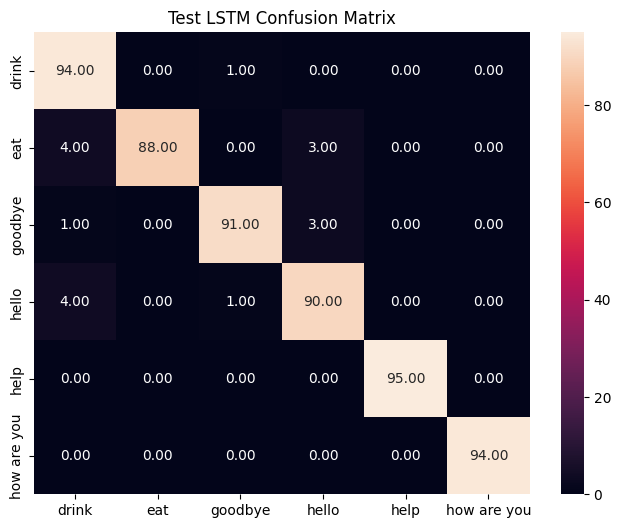

In [ ]:
cm = confusion_matrix(ytrue, yhat)

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt=".2f", yticklabels=actions, xticklabels=actions)

# Add title
plt.title('Test LSTM Confusion Matrix')

In [ ]:
accuracy_score(ytrue, yhat)

0.9701230228471002

## 5.2 Conv1D

In [ ]:
model_conv1d = Sequential()
model_conv1d.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model_conv1d.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_conv1d.add(Dropout(0.5))
model_conv1d.add(MaxPooling1D(pool_size=2))
model_conv1d.add(Flatten())
model_conv1d.add(Dense(100, activation='relu'))
model_conv1d.add(Dense(actions.shape[0], activation='softmax'))
model_conv1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_conv1d.load_weights(os.path.join(MODELS_PATH, 'model_conv1d.h5'))

In [ ]:
yhat = model_conv1d.predict(X_test)

18/18 [==============================] - 0s 4ms/step


In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[474,   0],
        [  0,  95]],

       [[473,   1],
        [  0,  95]],

       [[474,   0],
        [  1,  94]],

       [[474,   0],
        [  0,  95]],

       [[473,   1],
        [  0,  95]],

       [[475,   0],
        [  1,  93]]], dtype=int64)

Text(0.5, 1.0, 'Test Conv1D Confusion Matrix')

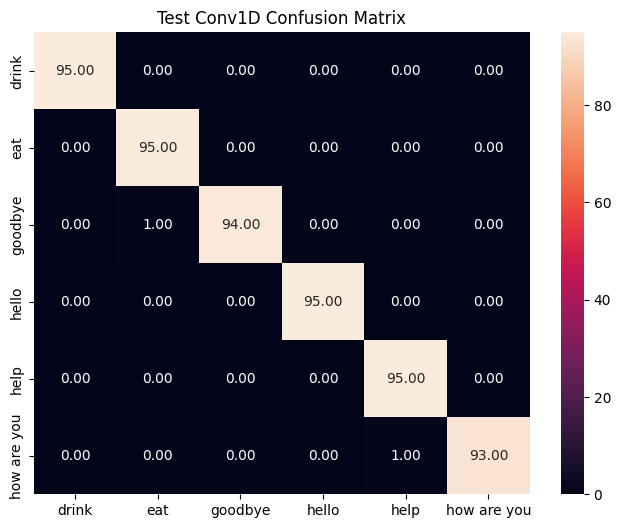

In [ ]:
cm = confusion_matrix(ytrue, yhat)

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt=".2f", yticklabels=actions, xticklabels=actions)

# Add title
plt.title('Test Conv1D Confusion Matrix')

In [ ]:
accuracy_score(ytrue, yhat)

0.9964850615114236

## 5.3 Transformer


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(actions.shape[0], activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
model_transformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
model_transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 84)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 30, 84)               168       ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 30, 84)               347220    ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [ ]:
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["categorical_accuracy"],
)

In [ ]:
model_transformer.load_weights(os.path.join(MODELS_PATH, 'model_transformer.h5'))

In [ ]:
yhat = model_transformer.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
cm = confusion_matrix(ytrue, yhat)

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt=".2f", yticklabels=actions, xticklabels=actions)

# Add title
plt.title('Test Transformer Confusion Matrix')

In [ ]:
accuracy_score(ytrue, yhat)

0.9964850615114236

# 6. Test in Real Time

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245), (255, 0, 0), (0, 255, 0), (0, 0, 255)] #NOTE: No. of colors = No. of action
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        print(actions[num], prob)
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, f"{actions[num]}: {prob*100:.2f}%", (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    return output_frame


In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)

        lh_rh = keypoints[1536:]
        #Remove z Axis From Landmarks
        for z in range(2,lh_rh.shape[0],3):
            lh_rh[z] = None
        #Remove NaN Data
        lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
        sequence.append(lh_rh)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            # Convert sequence to numpy array
            sequence_array = np.array(sequence)

            # Reshape sequence_array to match model input shape
            sequence_array = np.expand_dims(sequence_array, axis=0)  # Add batch dimension
            sequence_array = sequence_array.reshape((1, 30, -1))  # Reshape to (1, 30, features)
            res = model.predict(sequence_array)[0]
            print("res", res)
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# 7. Test From video

In [ ]:
video_path = os.path.join(ROOT, 'drink.mp4')

In [ ]:
# Initialize MediaPipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Load the model and define other necessary variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

# Load the video file
cap = cv2.VideoCapture(video_path)
start_time = time.time()
print('start')
print("total frames count: ",int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()

    # If there are no more frames, break the loop
    if not ret:
        print("No more frames. Exiting loop.")
        break

    # print("Frame read successfully.")

    # Make detections
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        image, results = mediapipe_detection(frame, holistic)
        # print("Detections made.")

    # Prediction logic
    keypoints = extract_keypoints(results)
    lh_rh = keypoints[1536:]
    #Remove z Axis From Landmarks
    for z in range(2,lh_rh.shape[0],3):
        lh_rh[z] = None
    #Remove NaN Data
    lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
    sequence.append(lh_rh)
    sequence = sequence[-30:]
    # print("keypoints extracted.")
    if len(sequence) == 30:
        res = model_lstm.predict(np.expand_dims(sequence, axis=0))[0]
        print(f"Model prediction made. {actions[np.argmax(res)]}")
        predictions.append(np.argmax(res))

        if np.unique(predictions[-10:])[0] == np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
        # sequence = []
        # if len(sentence) > 5:
        #     sentence = sentence[-5:]



# Calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time taken: {:.2f} seconds".format(elapsed_time))
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
sentence